**Libraries**

In [ ]:
import numpy as np
import pandas as pd
import os
import re
import tensorflow as tf
from threading import Thread
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.offline import init_notebook_mode
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201, Xception
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
init_notebook_mode(connected=True)

**Import data from kaggle**

In [ ]:
!kaggle datasets download -d paramaggarwal/fashion-product-images-dataset

Dataset URL: https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-dataset
License(s): copyright-authors
100% 23.0G/23.1G [04:44<00:00, 104MB/s] 
100% 23.1G/23.1G [04:44<00:00, 87.1MB/s]


**Extract files from dataset.zip**

In [ ]:
from zipfile import ZipFile
from tqdm import tqdm
file_name = "/content/fashion-product-images-dataset.zip"
with ZipFile(file_name, 'r') as ziip:
    file_list = ziip.namelist()
    with tqdm(total=len(file_list), unit='file') as pbar:
        for file in file_list:
            ziip.extract(file)
            pbar.update(1)
    print('Extraction done')
print("Script execution completed.")

100%|██████████| 177778/177778 [06:46<00:00, 437.06file/s] 

Extraction done
Script execution completed.


In [ ]:
import os

def count_images_in_folder(folder_path):
    """
    Counts the number of image files in a specified folder.

    Parameters:
    folder_path (str): Path to the folder to count image files in.

    Returns:
    int: Number of image files in the folder.
    """
    image_extensions = {'.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff', '.tif', '.webp'}
    files = os.listdir(folder_path)
    image_files = [file for file in files if os.path.splitext(file)[1].lower() in image_extensions]
    image_count = len(image_files)

    return image_count

folder_path = "/content/fashion-dataset/fashion-dataset/images"
image_count = count_images_in_folder(folder_path)
print(f"There are {image_count} image(s) in the folder '{folder_path}'.")


There are 44441 image(s) in the folder '/content/fashion-dataset/fashion-dataset/images'.


In [ ]:
import shutil
import os

def force_delete_folder(folder_path):
    """
    Forcefully deletes a folder and all its contents.

    Parameters:
    folder_path (str): Path to the folder to be deleted.
    """
    try:
        if os.path.exists(folder_path):
            print(f"Deleting folder and all contents: {folder_path}")
            shutil.rmtree(folder_path)
            print("Folder deleted successfully.")
        else:
            print(f"The folder '{folder_path}' does not exist.")
    except Exception as e:
        print(f"An error occurred while deleting the folder: {e}")

folder_path = "/content/fashion-dataset/styles"
force_delete_folder(folder_path)


Deleting folder and all contents: /content/fashion-dataset/styles
Folder deleted successfully.


**Mount Google Drive**

In [ ]:
from google.colab import drive
import os
import shutil

drive.mount('/content/drive')

drive_folder_path = '/content/drive/MyDrive/Colab Notebooks'

os.makedirs(drive_folder_path, exist_ok=True)


Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/features.csv')
df

,filename,0,1,2,3,4,5,6,7,8,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,58528.jpg,0.097000,0.409907,0.736060,0.017250,0.181814,0.269502,0.511592,0.072754,0.019670,...,0.178964,0.105465,0.419077,0.403322,0.087037,0.305624,0.250152,0.387852,0.371818,0.031485
1,43697.jpg,0.409239,0.598185,0.427249,0.023408,0.351980,0.472945,0.800061,0.534895,0.800306,...,0.094245,0.308207,0.542434,0.328967,1.447281,0.131039,0.298698,0.496187,0.503994,0.397703
2,26945.jpg,0.514342,0.482240,0.433666,0.022358,0.465195,0.209212,0.598329,0.219593,0.594645,...,0.052589,0.165394,0.544382,0.281061,0.183756,0.186706,0.179006,0.383560,0.535600,0.219412
3,34241.jpg,0.497983,1.224336,0.421257,0.006929,0.227544,0.218529,0.353141,0.531019,0.564130,...,0.312341,0.493572,0.240569,0.452595,0.700527,0.105645,0.093612,0.327202,0.593794,0.790127
4,16527.jpg,0.177116,0.376569,0.096202,0.079835,0.338958,0.257495,0.608206,0.200956,0.215071,...,0.476488,0.254100,0.427570,0.204112,0.781744,0.036076,0.083281,0.110411,0.712178,0.328091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17051,54641.jpg,0.465589,0.365099,0.196514,0.332738,0.414535,0.751511,0.996852,0.108700,0.253985,...,0.916949,0.205815,0.493364,0.498373,0.469410,0.448280,0.033688,0.709167,0.140718,0.276660
17052,11059.jpg,0.183297,0.797128,0.246359,0.078843,0.570024,0.355817,1.501374,0.257246,0.191414,...,0.247786,0.087101,0.216807,0.274575,0.530801,0.141682,0.297371,0.102989,0.234608,0.397071
17053,12386.jpg,0.325074,0.546360,0.233769,0.128486,0.270657,0.185931,2.469497,0.322730,0.506570,...,0.191953,0.341082,0.634317,0.629860,0.417588,0.317019,0.196506,0.289124,0.009831,0.761023
17054,8185.jpg,0.186840,0.473157,0.417788,0.044745,0.351985,0.278505,0.658957,0.128122,0.278564,...,0.359812,0.138000,0.183963,0.230120,0.492124,0.093584,0.180719,0.074746,0.529464,0.277880


In [ ]:
df_2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/df_without_usage.csv')
df_2.head(10)

,filename,0,1,2,3,4,5,6,7,8,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,articleType
0,58528.jpg,0.097000,0.409907,0.736060,0.017250,0.181814,0.269502,0.511592,0.072754,0.019670,...,0.105465,0.419077,0.403322,0.087037,0.305624,0.250152,0.387852,0.371818,0.031485,5
1,43697.jpg,0.409239,0.598185,0.427249,0.023408,0.351980,0.472945,0.800061,0.534895,0.800306,...,0.308207,0.542434,0.328967,1.447281,0.131039,0.298698,0.496187,0.503994,0.397703,7
2,26945.jpg,0.514342,0.482240,0.433666,0.022358,0.465195,0.209212,0.598329,0.219593,0.594645,...,0.165394,0.544382,0.281061,0.183756,0.186706,0.179006,0.383560,0.535600,0.219412,7
3,34241.jpg,0.497983,1.224336,0.421257,0.006929,0.227544,0.218529,0.353141,0.531019,0.564130,...,0.493572,0.240569,0.452595,0.700527,0.105645,0.093612,0.327202,0.593794,0.790127,7
4,16527.jpg,0.177116,0.376569,0.096202,0.079835,0.338958,0.257495,0.608206,0.200956,0.215071,...,0.254100,0.427570,0.204112,0.781744,0.036076,0.083281,0.110411,0.712178,0.328091,4


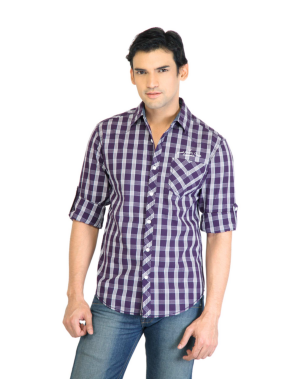

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image

def display_image(image_path):
    image = Image.open(image_path)

    plt.imshow(image)
    plt.axis('off')
    plt.show()
filename = '16527.jpg'


folder_path = "filtered_images"
image_path = os.path.join(folder_path, filename)


display_image(image_path)


**Data Preparing**

In [ ]:
import numpy as np
import pandas as pd
import os

images = pd.read_csv("/content/fashion-dataset/fashion-dataset/images.csv", on_bad_lines='skip')
styles = pd.read_csv("/content/fashion-dataset/fashion-dataset/styles.csv", on_bad_lines='skip')

images['id'] = images['filename'].apply(lambda x: x.replace(".jpg","")).astype(int)

images

,filename,link,id
0,15970.jpg,http://assets.myntassets.com/v1/images/style/p...,15970
1,39386.jpg,http://assets.myntassets.com/v1/images/style/p...,39386
2,59263.jpg,http://assets.myntassets.com/v1/images/style/p...,59263
3,21379.jpg,http://assets.myntassets.com/v1/images/style/p...,21379
4,53759.jpg,http://assets.myntassets.com/v1/images/style/p...,53759
...,...,...,...
44441,17036.jpg,http://assets.myntassets.com/v1/images/style/p...,17036
44442,6461.jpg,http://assets.myntassets.com/v1/images/style/p...,6461
44443,18842.jpg,http://assets.myntassets.com/v1/images/style/p...,18842
44444,46694.jpg,http://assets.myntassets.com/v1/images/style/p...,46694


In [ ]:
data = styles.merge(images,on='id',how='left').reset_index(drop=True)
data['filename'] = data['filename'].apply(lambda x: os.path.join("/content/fashion-dataset/fashion-dataset/images",x))

data

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,filename,link
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,/content/fashion-dataset/fashion-dataset/image...,http://assets.myntassets.com/v1/images/style/p...
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,/content/fashion-dataset/fashion-dataset/image...,http://assets.myntassets.com/v1/images/style/p...
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,/content/fashion-dataset/fashion-dataset/image...,http://assets.myntassets.com/v1/images/style/p...
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,/content/fashion-dataset/fashion-dataset/image...,http://assets.myntassets.com/v1/images/style/p...
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,/content/fashion-dataset/fashion-dataset/image...,http://assets.myntassets.com/v1/images/style/p...
...,...,...,...,...,...,...,...,...,...,...,...,...
44419,17036,Men,Footwear,Shoes,Casual Shoes,White,Summer,2013.0,Casual,Gas Men Caddy Casual Shoe,/content/fashion-dataset/fashion-dataset/image...,http://assets.myntassets.com/v1/images/style/p...
44420,6461,Men,Footwear,Flip Flops,Flip Flops,Red,Summer,2011.0,Casual,Lotto Men's Soccer Track Flip Flop,/content/fashion-dataset/fashion-dataset/image...,http://assets.myntassets.com/v1/images/style/p...
44421,18842,Men,Apparel,Topwear,Tshirts,Blue,Fall,2011.0,Casual,Puma Men Graphic Stellar Blue Tshirt,/content/fashion-dataset/fashion-dataset/image...,http://assets.myntassets.com/v1/images/style/p...
44422,46694,Women,Personal Care,Fragrance,Perfume and Body Mist,Blue,Spring,2017.0,Casual,Rasasi Women Blue Lady Perfume,/content/fashion-dataset/fashion-dataset/image...,http://assets.myntassets.com/v1/images/style/p...


In [ ]:
image_files = os.listdir("/content/fashion-dataset/fashion-dataset/images")

In [ ]:
data['file_found'] = data['id'].apply(lambda x: f"{x}.jpg" in image_files)
data = data[data['file_found']].reset_index(drop=True)

data.drop(columns=['season','link','file_found','year'],inplace=True)
keep_data = ['Shirts', 'Tshirts', 'Watches', 'Heels','Flats', 'Handbags', 'Sports Shoes', 'Jeans','Sunglasses',
                         'Trousers', 'Jackets',  'Blazers']

finaldata = data[data['articleType'].isin(keep_data)]
finaldata

,id,gender,masterCategory,subCategory,articleType,baseColour,usage,productDisplayName,filename
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Casual,Turtle Check Men Navy Blue Shirt,/content/fashion-dataset/fashion-dataset/image...
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Casual,Peter England Men Party Blue Jeans,/content/fashion-dataset/fashion-dataset/image...
2,59263,Women,Accessories,Watches,Watches,Silver,Casual,Titan Women Silver Watch,/content/fashion-dataset/fashion-dataset/image...
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Casual,Puma Men Grey T-shirt,/content/fashion-dataset/fashion-dataset/image...
5,1855,Men,Apparel,Topwear,Tshirts,Grey,Casual,Inkfruit Mens Chain Reaction T-shirt,/content/fashion-dataset/fashion-dataset/image...
...,...,...,...,...,...,...,...,...,...
44409,30614,Men,Apparel,Topwear,Tshirts,Black,Sports,Nike Men Striped Black Jersey,/content/fashion-dataset/fashion-dataset/image...
44410,13496,Men,Apparel,Topwear,Tshirts,Blue,Casual,Chimp Men Teja Main Hoon Blue Tshirts,/content/fashion-dataset/fashion-dataset/image...
44412,12544,Women,Apparel,Topwear,Tshirts,Peach,Casual,Tantra Women Printed Peach T-shirt,/content/fashion-dataset/fashion-dataset/image...
44416,18842,Men,Apparel,Topwear,Tshirts,Blue,Casual,Puma Men Graphic Stellar Blue Tshirt,/content/fashion-dataset/fashion-dataset/image...


In [ ]:
article = finaldata['articleType'].unique()

for article_type in article :
    print(article_type)

Shirts
Jeans
Watches
Tshirts
Handbags
Flats
Sports Shoes
Heels
Sunglasses
Blazers
Trousers
Jackets


In [ ]:
article_to_exclude = ['Free Gifts','belts' ]
finaldata = finaldata[~finaldata['subCategory'].isin(article_to_exclude)]

finaldata

,id,gender,masterCategory,subCategory,articleType,baseColour,usage,productDisplayName,filename
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Casual,Turtle Check Men Navy Blue Shirt,/content/fashion-dataset/fashion-dataset/image...
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Casual,Peter England Men Party Blue Jeans,/content/fashion-dataset/fashion-dataset/image...
2,59263,Women,Accessories,Watches,Watches,Silver,Casual,Titan Women Silver Watch,/content/fashion-dataset/fashion-dataset/image...
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Casual,Puma Men Grey T-shirt,/content/fashion-dataset/fashion-dataset/image...
5,1855,Men,Apparel,Topwear,Tshirts,Grey,Casual,Inkfruit Mens Chain Reaction T-shirt,/content/fashion-dataset/fashion-dataset/image...
...,...,...,...,...,...,...,...,...,...
44409,30614,Men,Apparel,Topwear,Tshirts,Black,Sports,Nike Men Striped Black Jersey,/content/fashion-dataset/fashion-dataset/image...
44410,13496,Men,Apparel,Topwear,Tshirts,Blue,Casual,Chimp Men Teja Main Hoon Blue Tshirts,/content/fashion-dataset/fashion-dataset/image...
44412,12544,Women,Apparel,Topwear,Tshirts,Peach,Casual,Tantra Women Printed Peach T-shirt,/content/fashion-dataset/fashion-dataset/image...
44416,18842,Men,Apparel,Topwear,Tshirts,Blue,Casual,Puma Men Graphic Stellar Blue Tshirt,/content/fashion-dataset/fashion-dataset/image...


In [ ]:
price_ranges = {
    'Topwear': (500, 1000),
    'shoes': (700, 1200),
    'Watches': (1700, 3200),
    'Bags': (700, 1200),
    'Bottomwear': (500, 1000),
    'Eyewear': (1200, 2500)
}
def assign_price(subcategory):
    if subcategory in price_ranges:
        return np.random.randint(price_ranges[subcategory][0], price_ranges[subcategory][1] + 1)
    return np.nan


finaldata['Price'] = finaldata['subCategory'].apply(assign_price)

<ipython-input-16-af7a0353bcdf>:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
selected_columns = finaldata[['subCategory', 'Price']]

print(selected_columns.head())

  subCategory   Price
0     Topwear   858.0
1  Bottomwear   584.0
2     Watches  1817.0
4     Topwear   820.0
5     Topwear   621.0


In [ ]:
locations = ['october', 'zayed', 'maadi', 'mokatam', 'nasr city', 'mohandseen', 'new cairo']
finaldata['Location'] = np.random.choice(locations, size=len(finaldata))

vendors = { 'october': ['OctoShop', 'FashionFactory', 'StyleHut'],
    'zayed': ['ZayedZone', 'ElegantWear', 'FashionPalace', 'TrendyThreads'],
    'maadi': ['MaadiMart', 'ChicBoutique', 'UrbanAttire', 'VogueVista'],
    'mokatam': ['MokatamModa', 'StyleCentral', 'FashionFiesta', 'ClassyCloset'],
    'nasr city': ['NasrNook', 'GlamourGrove', 'StylishStop', 'FashionFrenzy'],
    'mohandseen': ['MohandseenMarket', 'ElegantEmpire', 'TrendyTerrace', 'VogueVault'],
    'new cairo': ['CairoCouture', 'FashionFront', 'ChicCorner', 'UrbanUtopia']
}

finaldata['Vendor'] = finaldata['Location'].apply(lambda loc: np.random.choice( vendors[loc]))
finaldata.loc[finaldata['articleType'] == 'Blazers', 'Location'] = 'October'
finaldata

<ipython-input-18-5dc355c07fa4>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-18-5dc355c07fa4>:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,id,gender,masterCategory,subCategory,articleType,baseColour,usage,productDisplayName,filename,Price,Location,Vendor
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Casual,Turtle Check Men Navy Blue Shirt,/content/fashion-dataset/fashion-dataset/image...,858.0,nasr city,StylishStop
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Casual,Peter England Men Party Blue Jeans,/content/fashion-dataset/fashion-dataset/image...,584.0,maadi,MaadiMart
2,59263,Women,Accessories,Watches,Watches,Silver,Casual,Titan Women Silver Watch,/content/fashion-dataset/fashion-dataset/image...,1817.0,new cairo,ChicCorner
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Casual,Puma Men Grey T-shirt,/content/fashion-dataset/fashion-dataset/image...,820.0,new cairo,CairoCouture
5,1855,Men,Apparel,Topwear,Tshirts,Grey,Casual,Inkfruit Mens Chain Reaction T-shirt,/content/fashion-dataset/fashion-dataset/image...,621.0,mohandseen,MohandseenMarket
...,...,...,...,...,...,...,...,...,...,...,...,...
44409,30614,Men,Apparel,Topwear,Tshirts,Black,Sports,Nike Men Striped Black Jersey,/content/fashion-dataset/fashion-dataset/image...,949.0,zayed,ZayedZone
44410,13496,Men,Apparel,Topwear,Tshirts,Blue,Casual,Chimp Men Teja Main Hoon Blue Tshirts,/content/fashion-dataset/fashion-dataset/image...,850.0,october,OctoShop
44412,12544,Women,Apparel,Topwear,Tshirts,Peach,Casual,Tantra Women Printed Peach T-shirt,/content/fashion-dataset/fashion-dataset/image...,752.0,maadi,ChicBoutique
44416,18842,Men,Apparel,Topwear,Tshirts,Blue,Casual,Puma Men Graphic Stellar Blue Tshirt,/content/fashion-dataset/fashion-dataset/image...,617.0,mohandseen,ElegantEmpire


In [ ]:
counts = finaldata.groupby('articleType').size()
print(counts)

articleType
Blazers            8
Flats            500
Handbags        1757
Heels           1323
Jackets          258
Jeans            608
Shirts          3215
Sports Shoes    2036
Sunglasses      1073
Trousers         530
Tshirts         7066
Watches         2542
dtype: int64


In [ ]:
finaldata_cleaned = finaldata.dropna(subset=['Price'])

print(f"Original data shape: {finaldata.shape}")
print(f"Data shape after removing nulls: {finaldata_cleaned.shape}")

Original data shape: (20916, 12)
Data shape after removing nulls: (17056, 12)


In [ ]:
import shutil

finaldata_path = '/content/csv/finaldata2_data.csv'
finaldata_cleaned.to_csv(finaldata_path, index=False)

In [ ]:
import os
import shutil
from tqdm import tqdm

filtered_images_folder = 'filtered_images'
os.makedirs(filtered_images_folder, exist_ok=True)

images_directory = '/content/fashion-dataset/fashion-dataset/images'
skipped_images = []

for idx, row in tqdm(finaldata_cleaned.iterrows(), total=finaldata_cleaned.shape[0], unit='image'):
    filename = os.path.basename(row['filename'])
    source = os.path.join(images_directory, filename)
    destination = os.path.join(filtered_images_folder, filename)
    if os.path.exists(source):
        shutil.copyfile(source, destination)
    else:
        skipped_images.append(filename)
        print(f"Skipped {filename} as it does not exist")

print(f"Copied {len(finaldata_cleaned) - len(skipped_images)} images to the folder '{filtered_images_folder}'")
print(f"Skipped {len(skipped_images)} images that do not exist")


100%|██████████| 17056/17056 [01:45<00:00, 161.80image/s]

Copied 17056 images to the folder 'filtered_images'
Skipped 0 images that do not exist


**Images Features Import from github**


In [ ]:
!pip install -U git+https://github.com/chsasank/image_features.git

  Cloning https://github.com/chsasank/image_features.git to /tmp/pip-req-build-mb10wi49
  Running command git clone --filter=blob:none --quiet https://github.com/chsasank/image_features.git /tmp/pip-req-build-mb10wi49
  Resolved https://github.com/chsasank/image_features.git to commit d82fb550a2d760a5ec730e663f709b4cf86576f8
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (12

**Model**

In [ ]:
df_articleType_withName = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/df_without_usage.csv')

In [ ]:
df_articleType = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/df_without_usage.csv')
df_articleType.drop(columns=['filename'], inplace=True)
df_articleType

,0,1,2,3,4,5,6,7,8,9,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,articleType
0,0.097000,0.409907,0.736060,0.017250,0.181814,0.269502,0.511592,0.072754,0.019670,0.255558,...,0.105465,0.419077,0.403322,0.087037,0.305624,0.250152,0.387852,0.371818,0.031485,5
1,0.409239,0.598185,0.427249,0.023408,0.351980,0.472945,0.800061,0.534895,0.800306,0.342843,...,0.308207,0.542434,0.328967,1.447281,0.131039,0.298698,0.496187,0.503994,0.397703,7
2,0.514342,0.482240,0.433666,0.022358,0.465195,0.209212,0.598329,0.219593,0.594645,0.162221,...,0.165394,0.544382,0.281061,0.183756,0.186706,0.179006,0.383560,0.535600,0.219412,7
3,0.497983,1.224336,0.421257,0.006929,0.227544,0.218529,0.353141,0.531019,0.564130,0.583842,...,0.493572,0.240569,0.452595,0.700527,0.105645,0.093612,0.327202,0.593794,0.790127,7
4,0.177116,0.376569,0.096202,0.079835,0.338958,0.257495,0.608206,0.200956,0.215071,0.635102,...,0.254100,0.427570,0.204112,0.781744,0.036076,0.083281,0.110411,0.712178,0.328091,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17051,0.465589,0.365099,0.196514,0.332738,0.414535,0.751511,0.996852,0.108700,0.253985,0.206370,...,0.205815,0.493364,0.498373,0.469410,0.448280,0.033688,0.709167,0.140718,0.276660,8
17052,0.183297,0.797128,0.246359,0.078843,0.570024,0.355817,1.501374,0.257246,0.191414,0.728299,...,0.087101,0.216807,0.274575,0.530801,0.141682,0.297371,0.102989,0.234608,0.397071,4
17053,0.325074,0.546360,0.233769,0.128486,0.270657,0.185931,2.469497,0.322730,0.506570,0.312546,...,0.341082,0.634317,0.629860,0.417588,0.317019,0.196506,0.289124,0.009831,0.761023,4
17054,0.186840,0.473157,0.417788,0.044745,0.351985,0.278505,0.658957,0.128122,0.278564,0.849617,...,0.138000,0.183963,0.230120,0.492124,0.093584,0.180719,0.074746,0.529464,0.277880,4


In [ ]:
from sklearn.model_selection import train_test_split

X = df_articleType.iloc[:,:-1]
y = df_articleType.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))

unique_labels = y.unique()
target_names = [str(label) for label in unique_labels]
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=target_names))

Accuracy: 0.9756740914419695
Classification Report:
               precision    recall  f1-score   support

           5       0.00      0.00      0.00         1
           7       1.00      1.00      1.00       332
           4       1.00      0.41      0.58        59
           8       0.94      0.96      0.95       122
           6       0.95      0.97      0.96       652
           1       1.00      1.00      1.00       223
           3       0.95      0.93      0.94       114
           0       0.97      0.99      0.98      1406
           2       1.00      1.00      1.00       503

    accuracy                           0.98      3412
   macro avg       0.87      0.81      0.82      3412
weighted avg       0.98      0.98      0.97      3412



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
import joblib

joblib.dump(model, 'clothing_classifier.pkl')


['clothing_classifier.pkl']

In [ ]:
import os
import pandas as pd
from image_features import image_features
import glob
from tqdm import tqdm

test_folder = '/content/test'

def extract_features_from_folder(folder_path, batch_size=32):
    features = []
    labels = []

    image_paths = glob.glob(os.path.join(folder_path, '*'))
    total_files = len(image_paths)

    with tqdm(total=total_files, unit='file') as pbar:
        for i in range(0, len(image_paths), batch_size):
            batch_paths = image_paths[i:i + batch_size]
            batch_features = image_features(batch_paths)

            for file_path, feature_vector in zip(batch_paths, batch_features):
                filename = os.path.basename(file_path)
                features.append(feature_vector)
                labels.append(filename)

            pbar.update(len(batch_paths))

    return features, labels
batch_size = 32

features, labels = extract_features_from_folder(test_folder, batch_size=batch_size)

features_df = pd.DataFrame(features)
labels_df = pd.DataFrame(labels, columns=['filename'])
df = pd.concat([labels_df, features_df], axis=1)

df.to_csv('image_features.csv', index=False)

print("Feature extraction completed. Features are saved in 'features.csv'.")


  0%|          | 0/1 [00:00<?, ?file/s]/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning:

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.

/usr/lib/python3.10/multiprocessing/popen_fork

Feature extraction completed. Features are saved in 'features.csv'.


In [ ]:
import pandas as pd
import joblib

model = joblib.load('clothing_classifier.pkl')

new_features = pd.read_csv('image_features.csv')
new_features.drop(columns=['filename'], inplace=True)
predictions = model.predict(new_features)


print("Predicted Labels:")
print(predictions)


Predicted Labels:
[7]


In [ ]:
filtered_df = df_articleType_withName[df_articleType_withName['articleType'].isin(predictions)]
print("Filtered DataFrame:")
filtered_df.to_csv('filtered_df.csv', index=False)
filtered_df

Filtered DataFrame:


,filename,0,1,2,3,4,5,6,7,8,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,articleType
1,43697.jpg,0.409239,0.598185,0.427249,0.023408,0.351980,0.472945,0.800061,0.534895,0.800306,...,0.308207,0.542434,0.328967,1.447281,0.131039,0.298698,0.496187,0.503994,0.397703,7
2,26945.jpg,0.514342,0.482240,0.433666,0.022358,0.465195,0.209212,0.598329,0.219593,0.594645,...,0.165394,0.544382,0.281061,0.183756,0.186706,0.179006,0.383560,0.535600,0.219412,7
3,34241.jpg,0.497983,1.224336,0.421257,0.006929,0.227544,0.218529,0.353141,0.531019,0.564130,...,0.493572,0.240569,0.452595,0.700527,0.105645,0.093612,0.327202,0.593794,0.790127,7
5,10447.jpg,0.319420,0.688657,0.137788,0.093863,0.202801,0.193012,0.640590,0.851664,0.505789,...,0.481160,0.215563,0.289469,0.794493,0.094456,0.280405,0.215739,0.411623,0.480155,7
6,3071.jpg,0.234058,1.005967,0.390603,0.102390,0.780417,0.133870,0.391903,0.026010,0.325269,...,0.454430,0.790885,0.469361,0.277227,0.234522,0.109651,0.624687,0.628762,0.250161,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17044,8613.jpg,0.253500,0.640185,0.115127,0.085882,0.504084,0.712376,0.514657,0.054573,0.294206,...,0.071295,0.327304,0.468569,0.963619,0.229779,0.043321,0.337802,0.504730,0.411058,7
17045,32482.jpg,0.516918,1.035860,0.216434,0.000043,0.227027,0.183755,0.821922,0.291058,0.561890,...,0.388583,0.406971,0.521941,1.056329,0.119661,0.188170,0.172558,0.468034,0.351354,7
17047,31452.jpg,0.140864,0.906857,0.150370,0.079410,0.735887,0.175231,0.390104,0.358248,1.403417,...,0.401165,0.556843,0.293406,0.037404,0.113635,0.262771,0.340191,0.084778,0.337200,7
17049,28865.jpg,0.424291,1.311798,0.195265,0.006001,0.447532,0.519456,0.399213,0.299570,0.921603,...,0.306621,0.815614,0.227090,0.415229,0.052208,0.175311,0.318815,0.336547,0.665990,7


In [ ]:
finaldata_cleaned

,id,gender,masterCategory,subCategory,articleType,baseColour,usage,productDisplayName,filename,Price,Location,Vendor
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Casual,Turtle Check Men Navy Blue Shirt,/content/fashion-dataset/fashion-dataset/image...,858.0,nasr city,StylishStop
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Casual,Peter England Men Party Blue Jeans,/content/fashion-dataset/fashion-dataset/image...,584.0,maadi,MaadiMart
2,59263,Women,Accessories,Watches,Watches,Silver,Casual,Titan Women Silver Watch,/content/fashion-dataset/fashion-dataset/image...,1817.0,new cairo,ChicCorner
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Casual,Puma Men Grey T-shirt,/content/fashion-dataset/fashion-dataset/image...,820.0,new cairo,CairoCouture
5,1855,Men,Apparel,Topwear,Tshirts,Grey,Casual,Inkfruit Mens Chain Reaction T-shirt,/content/fashion-dataset/fashion-dataset/image...,621.0,mohandseen,MohandseenMarket
...,...,...,...,...,...,...,...,...,...,...,...,...
44409,30614,Men,Apparel,Topwear,Tshirts,Black,Sports,Nike Men Striped Black Jersey,/content/fashion-dataset/fashion-dataset/image...,949.0,zayed,ZayedZone
44410,13496,Men,Apparel,Topwear,Tshirts,Blue,Casual,Chimp Men Teja Main Hoon Blue Tshirts,/content/fashion-dataset/fashion-dataset/image...,850.0,october,OctoShop
44412,12544,Women,Apparel,Topwear,Tshirts,Peach,Casual,Tantra Women Printed Peach T-shirt,/content/fashion-dataset/fashion-dataset/image...,752.0,maadi,ChicBoutique
44416,18842,Men,Apparel,Topwear,Tshirts,Blue,Casual,Puma Men Graphic Stellar Blue Tshirt,/content/fashion-dataset/fashion-dataset/image...,617.0,mohandseen,ElegantEmpire


Top 5 Similar Products:
31294.jpg
10069.jpg
3600.jpg
10058.jpg
18638.jpg


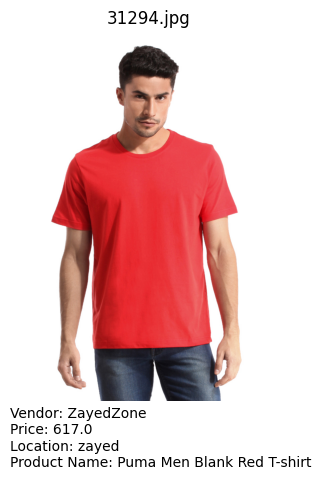

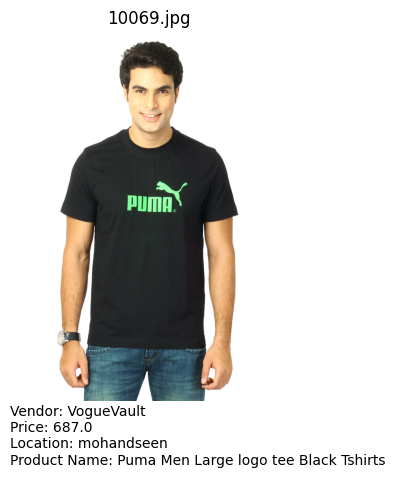

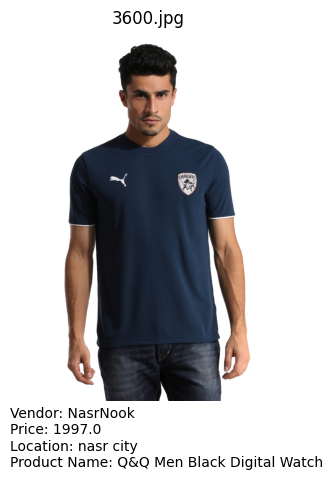

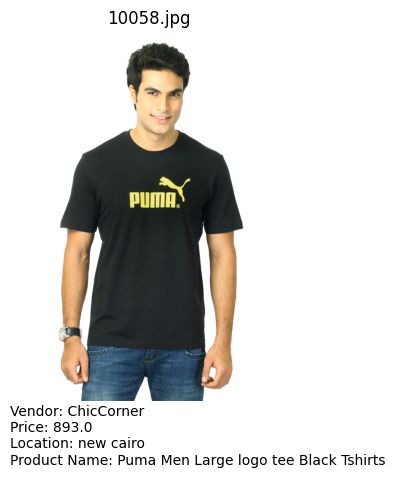

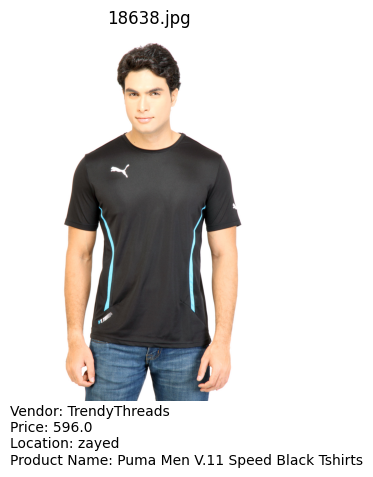

In [ ]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

filtered_df = pd.read_csv('filtered_df.csv')

new_input_features = pd.read_csv('image_features.csv')

input_features = new_input_features.drop(columns=['filename']).iloc[-1].values.reshape(1, -1)

similarities = cosine_similarity(filtered_df.drop(columns=['filename', 'articleType']), input_features)

top_indices = similarities.flatten().argsort()[-5:][::-1]

print("Top 5 Similar Products:")
for idx in top_indices:
    similar_filename = filtered_df.iloc[idx]['filename']
    similar_image_path = f"{folder_path}/{similar_filename}"
    print(similar_filename)

    img = mpimg.imread(similar_image_path)
    plt.figure()
    plt.imshow(img)
    plt.title(similar_filename)
    plt.axis('off')

    matching_row = finaldata_cleaned[finaldata_cleaned['filename'].str.contains(similar_filename)]

    if not matching_row.empty:

        vendor_name = matching_row['Vendor'].values[0]
        price = matching_row['Price'].values[0]
        location = matching_row['Location'].values[0]
        product_name = matching_row['productDisplayName'].values[0]

        plt.text(0, img.shape[0] + 20, f"Vendor: {vendor_name}\nPrice: {price}\nLocation: {location}\nProduct Name: {product_name}", fontsize=10, color='black', verticalalignment='top')
    else:

        plt.text(0, img.shape[0] + 20, "Vendor information not available", fontsize=10, color='red', verticalalignment='top')

plt.show()
